<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, with a small dataset (MNIST)
<!-- DESC --> Construction and training of a VAE with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/MNIST.001'                     # Output directory
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE1_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : VAE1
Run time             : Wednesday 27 January 2021, 19:25:18
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE1_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE1_done/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.2
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf


## Step 2 - Parameters
Uncomment the right lines according to what you want.

In [2]:
# ---- Smart tests
#
latent_dim    = 2
r_loss_factor = 0.994
scale         = 0.1
batch_size    = 64
epochs        = 10

# ---- Full run (1'30 on a V100)
#
# latent_dim    = 2
# r_loss_factor = 0.994
# scale         = 1.
# batch_size    = 64
# epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
latent_dim           : 2
r_loss_factor        : 0.994
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
### 3.1 - Get it

In [4]:
x_train, _ = Loader_MNIST.get()
np.random.shuffle(x_train)
nb_images = int(len(x_train)*scale)
x_train   = x_train[:nb_images]
print('\nTrain shape after rescale : ',x_train.shape)

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)



Train shape after rescale :  (70000, 28, 28, 1)


### 3.2 - Have a look

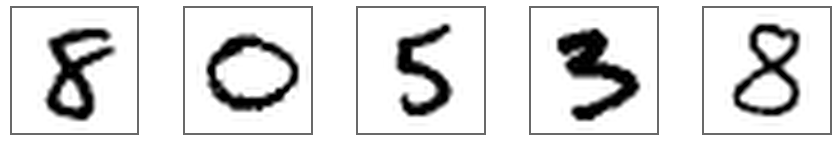

In [5]:
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=3,y_size=2, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [6]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [7]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [8]:
vae = VAE(encoder, decoder, r_loss_factor)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.994


## Step 5 - Train
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_train[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=2, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

# callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

In [10]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 0s - loss: 0.6893 - r_loss: 0.6934 - kl_loss: 2.0172e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.6393 - r_loss: 0.6398 - kl_loss: 0.5520    

  25/1094 [..............................] - ETA: 4s - loss: 0.5519 - r_loss: 0.5528 - kl_loss: 0.4116

  37/1094 [>.............................] - ETA: 4s - loss: 0.4841 - r_loss: 0.4853 - kl_loss: 0.2781

  49/1094 [>.............................] - ETA: 4s - loss: 0.4359 - r_loss: 0.4372 - kl_loss: 0.2100

  61/1094 [>.............................] - ETA: 4s - loss: 0.4036 - r_loss: 0.4050 - kl_loss: 0.1687

  73/1094 [=>............................] - ETA: 4s - loss: 0.3819 - r_loss: 0.3834 - kl_loss: 0.1410

  85/1094 [=>............................] - ETA: 4s - loss: 0.3656 - r_loss: 0.3670 - kl_loss: 0.1211

  97/1094 [=>............................] - ETA: 4s - loss: 0.3533 - r_loss: 0.3548 - kl_loss: 0.1061

 109/1094 [=>............................] - ETA: 4s - loss: 0.3440 - r_loss: 0.3455 - kl_loss: 0.0945

 121/1094 [==>...........................] - ETA: 4s - loss: 0.3365 - r_loss: 0.3380 - kl_loss: 0.0851

 133/1094 [==>...........................] - ETA: 4s - loss: 0.3302 - r_loss: 0.3317 - kl_loss: 0.0774

 145/1094 [==>...........................] - ETA: 4s - loss: 0.3247 - r_loss: 0.3262 - kl_loss: 0.0710

 157/1094 [===>..........................] - ETA: 3s - loss: 0.3201 - r_loss: 0.3216 - kl_loss: 0.0656

 169/1094 [===>..........................] - ETA: 3s - loss: 0.3163 - r_loss: 0.3179 - kl_loss: 0.0610

 181/1094 [===>..........................] - ETA: 3s - loss: 0.3127 - r_loss: 0.3143 - kl_loss: 0.0570

 193/1094 [====>.........................] - ETA: 3s - loss: 0.3097 - r_loss: 0.3112 - kl_loss: 0.0534

 205/1094 [====>.........................] - ETA: 3s - loss: 0.3071 - r_loss: 0.3086 - kl_loss: 0.0503

 217/1094 [====>.........................] - ETA: 3s - loss: 0.3046 - r_loss: 0.3061 - kl_loss: 0.0475

 229/1094 [=====>........................] - ETA: 3s - loss: 0.3023 - r_loss: 0.3038 - kl_loss: 0.0451

 241/1094 [=====>........................] - ETA: 3s - loss: 0.3001 - r_loss: 0.3017 - kl_loss: 0.0428

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2985 - r_loss: 0.3001 - kl_loss: 0.0408

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2968 - r_loss: 0.2983 - kl_loss: 0.0390

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2954 - r_loss: 0.2969 - kl_loss: 0.0373

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2940 - r_loss: 0.2955 - kl_loss: 0.0358

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2927 - r_loss: 0.2943 - kl_loss: 0.0344

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2916 - r_loss: 0.2932 - kl_loss: 0.0330

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2906 - r_loss: 0.2922 - kl_loss: 0.0318

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2896 - r_loss: 0.2912 - kl_loss: 0.0307

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2887 - r_loss: 0.2902 - kl_loss: 0.0297

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2878 - r_loss: 0.2894 - kl_loss: 0.0287

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2870 - r_loss: 0.2886 - kl_loss: 0.0278

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2862 - r_loss: 0.2878 - kl_loss: 0.0269

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2856 - r_loss: 0.2871 - kl_loss: 0.0261

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2847 - r_loss: 0.2863 - kl_loss: 0.0254

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2842 - r_loss: 0.2858 - kl_loss: 0.0247

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2835 - r_loss: 0.2851 - kl_loss: 0.0240

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2830 - r_loss: 0.2846 - kl_loss: 0.0234

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2824 - r_loss: 0.2840 - kl_loss: 0.0228

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2818 - r_loss: 0.2833 - kl_loss: 0.0222

 481/1094 [============>.................] - ETA: 2s - loss: 0.2813 - r_loss: 0.2829 - kl_loss: 0.0216

 493/1094 [============>.................] - ETA: 2s - loss: 0.2809 - r_loss: 0.2825 - kl_loss: 0.0211

 505/1094 [============>.................] - ETA: 2s - loss: 0.2805 - r_loss: 0.2821 - kl_loss: 0.0206

 517/1094 [=============>................] - ETA: 2s - loss: 0.2800 - r_loss: 0.2816 - kl_loss: 0.0202

 529/1094 [=============>................] - ETA: 2s - loss: 0.2796 - r_loss: 0.2812 - kl_loss: 0.0197

 541/1094 [=============>................] - ETA: 2s - loss: 0.2792 - r_loss: 0.2808 - kl_loss: 0.0193

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2788 - r_loss: 0.2804 - kl_loss: 0.0189

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2784 - r_loss: 0.2800 - kl_loss: 0.0185

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2780 - r_loss: 0.2796 - kl_loss: 0.0181

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2777 - r_loss: 0.2793 - kl_loss: 0.0178

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2773 - r_loss: 0.2789 - kl_loss: 0.0174

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2770 - r_loss: 0.2786 - kl_loss: 0.0171

 625/1094 [================>.............] - ETA: 1s - loss: 0.2767 - r_loss: 0.2783 - kl_loss: 0.0168

 637/1094 [================>.............] - ETA: 1s - loss: 0.2764 - r_loss: 0.2780 - kl_loss: 0.0165

 649/1094 [================>.............] - ETA: 1s - loss: 0.2762 - r_loss: 0.2777 - kl_loss: 0.0162

 661/1094 [=================>............] - ETA: 1s - loss: 0.2759 - r_loss: 0.2775 - kl_loss: 0.0159

 673/1094 [=================>............] - ETA: 1s - loss: 0.2757 - r_loss: 0.2773 - kl_loss: 0.0156

 685/1094 [=================>............] - ETA: 1s - loss: 0.2755 - r_loss: 0.2771 - kl_loss: 0.0154

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2753 - r_loss: 0.2769 - kl_loss: 0.0151

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2751 - r_loss: 0.2766 - kl_loss: 0.0149

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2748 - r_loss: 0.2764 - kl_loss: 0.0146

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2747 - r_loss: 0.2762 - kl_loss: 0.0144

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2744 - r_loss: 0.2760 - kl_loss: 0.0142

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2742 - r_loss: 0.2758 - kl_loss: 0.0140

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2739 - r_loss: 0.2755 - kl_loss: 0.0138

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2738 - r_loss: 0.2754 - kl_loss: 0.0136

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2736 - r_loss: 0.2752 - kl_loss: 0.0134

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2734 - r_loss: 0.2750 - kl_loss: 0.0132

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2732 - r_loss: 0.2748 - kl_loss: 0.0130

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2731 - r_loss: 0.2747 - kl_loss: 0.0128

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2729 - r_loss: 0.2745 - kl_loss: 0.0126

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2728 - r_loss: 0.2743 - kl_loss: 0.0125

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2727 - r_loss: 0.2742 - kl_loss: 0.0123

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2725 - r_loss: 0.2740 - kl_loss: 0.0121

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2723 - r_loss: 0.2739 - kl_loss: 0.0120

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2722 - r_loss: 0.2738 - kl_loss: 0.0118

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2720 - r_loss: 0.2736 - kl_loss: 0.0117

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2719 - r_loss: 0.2735 - kl_loss: 0.0115

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2718 - r_loss: 0.2734 - kl_loss: 0.0114

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2716 - r_loss: 0.2732 - kl_loss: 0.0113

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2715 - r_loss: 0.2731 - kl_loss: 0.0111

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2714 - r_loss: 0.2730 - kl_loss: 0.0110

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2713 - r_loss: 0.2729 - kl_loss: 0.0109

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2712 - r_loss: 0.2728 - kl_loss: 0.0108

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2711 - r_loss: 0.2726 - kl_loss: 0.0106

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2709 - r_loss: 0.2725 - kl_loss: 0.0105

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2709 - r_loss: 0.2724 - kl_loss: 0.0104

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2707 - r_loss: 0.2723 - kl_loss: 0.0103

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2707 - r_loss: 0.2722 - kl_loss: 0.0102

1069/1094 [============================>.] - ETA: 0s - loss: 0.2705 - r_loss: 0.2721 - kl_loss: 0.0101

1081/1094 [============================>.] - ETA: 0s - loss: 0.2704 - r_loss: 0.2720 - kl_loss: 0.0100

1093/1094 [============================>.] - ETA: 0s - loss: 0.2703 - r_loss: 0.2719 - kl_loss: 0.0099

1094/1094 [==============================] - ETA: 0s - loss: 0.2703 - r_loss: 0.2719 - kl_loss: 0.0099

Saved - loss=0.261914
1094/1094 [==============================] - 5s 5ms/step - loss: 0.2703 - r_loss: 0.2719 - kl_loss: 0.0099


Epoch 2/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2702 - r_loss: 0.2719 - kl_loss: 6.6473e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.2596 - r_loss: 0.2612 - kl_loss: 6.6625e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.6530e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.5805e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 6.5097e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 6.4416e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.2627 - r_loss: 0.2643 - kl_loss: 6.3828e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 6.3408e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.2628 - r_loss: 0.2644 - kl_loss: 6.3042e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.2625 - r_loss: 0.2640 - kl_loss: 6.2573e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2622 - r_loss: 0.2638 - kl_loss: 6.2130e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2618 - r_loss: 0.2633 - kl_loss: 6.1743e-04

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.1368e-04

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.1080e-04

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.0894e-04

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 6.0722e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.0601e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0437e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.0212e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.9958e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.9687e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.9419e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.9199e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.8990e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.8788e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.8584e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.8396e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.8240e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.8116e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.8006e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.7923e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.7863e-04

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.7794e-04

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.7689e-04

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.7534e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.7370e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.7200e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 5.7045e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.6914e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.6770e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.6634e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.6502e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.6385e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.6289e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.6197e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.6098e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.5991e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.5891e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 5.5782e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2618 - r_loss: 0.2633 - kl_loss: 5.5666e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.5556e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.5441e-04

 625/1094 [================>.............] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.5322e-04

 637/1094 [================>.............] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.5202e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.5103e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.5007e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.4888e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 5.4745e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.4597e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.4456e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.4323e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.4174e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.4010e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.3836e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.3663e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.3486e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.3303e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.3105e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.2891e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.2677e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 5.2466e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.2264e-04

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 5.2070e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.1881e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.1690e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.1489e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.1297e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.1111e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.0928e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.0741e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.0550e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.0359e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.0171e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 4.9984e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.9798e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.9605e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.9405e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.9215e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.9033e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.8862e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.8696e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.8532e-04

Saved - loss=0.258987
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.8506e-04


Epoch 3/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2590 - r_loss: 0.2605 - kl_loss: 3.4177e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.2604 - r_loss: 0.2620 - kl_loss: 3.4085e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 3.4006e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 3.3882e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 3.3687e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.2624 - r_loss: 0.2639 - kl_loss: 3.3496e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 3.3309e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.2627 - r_loss: 0.2642 - kl_loss: 3.3150e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 3.2970e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.2788e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 3.2607e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 3.2375e-04

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 3.2152e-04

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 3.1998e-04

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 3.1939e-04

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1889e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 3.1870e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1893e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1892e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1895e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1924e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1929e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.1944e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 3.1992e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.2050e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 3.2120e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 3.2187e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 3.2250e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2624 - r_loss: 0.2639 - kl_loss: 3.2310e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2622 - r_loss: 0.2638 - kl_loss: 3.2392e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 3.2453e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2622 - r_loss: 0.2637 - kl_loss: 3.2493e-04

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 3.2495e-04

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 3.2475e-04

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 3.2464e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2432e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 3.2391e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2634 - kl_loss: 3.2342e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.2303e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2339e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.2407e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2483e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2545e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2574e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2594e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2608e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.2609e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.2571e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2500e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.2432e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2388e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 3.2340e-04

 625/1094 [================>.............] - ETA: 1s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 3.2284e-04

 637/1094 [================>.............] - ETA: 1s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 3.2228e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 3.2158e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.2621 - r_loss: 0.2636 - kl_loss: 3.2071e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 3.1986e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 3.1899e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2619 - r_loss: 0.2634 - kl_loss: 3.1821e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.1759e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.1696e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.1622e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.1532e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.1432e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.1338e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.1242e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 3.1143e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.1036e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 3.0924e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.0796e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 3.0670e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.0560e-04

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.0451e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 3.0352e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 3.0257e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.0160e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.0066e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.9979e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.9894e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.9799e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.9699e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.9590e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.9475e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.9362e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.9247e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.9143e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.9051e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.8967e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.8888e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.8825e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 2.8770e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.8718e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.8709e-04


Epoch 4/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2519 - r_loss: 0.2534 - kl_loss: 2.3603e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.2640 - r_loss: 0.2656 - kl_loss: 2.3105e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.2632 - r_loss: 0.2648 - kl_loss: 2.2878e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.2627 - r_loss: 0.2642 - kl_loss: 2.2572e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 2.2158e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 2.1849e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 2.1634e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 2.1467e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 2.1311e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 2.1161e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 2.0911e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 2.0622e-04

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 2.0369e-04

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0114e-04

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2633 - kl_loss: 1.9864e-04

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 1.9625e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 1.9368e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2633 - kl_loss: 1.9153e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9098e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 1.9140e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.9248e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9388e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.9520e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.9666e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.9810e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.9959e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 2.0100e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 2.0206e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0260e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0266e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0274e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0327e-04

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0388e-04

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 2.0433e-04

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0439e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.0390e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 2.0302e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 2.0198e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2633 - kl_loss: 2.0089e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9996e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9909e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9810e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9697e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 1.9584e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9487e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.9400e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9313e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9199e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.9066e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 1.8919e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 1.8770e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 1.8629e-04

 625/1094 [================>.............] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.8488e-04

 637/1094 [================>.............] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.8363e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 1.8266e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.8194e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.8133e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.8070e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7992e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.7903e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7819e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7745e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7681e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7625e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7574e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 1.7529e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7485e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7457e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7449e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7441e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7444e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7451e-04

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7448e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7434e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7450e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7489e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7526e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7560e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7589e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7617e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.7665e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7711e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7754e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7793e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7808e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7798e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7778e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7751e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7729e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.7716e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.7688e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.7657e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.7652e-04


Epoch 5/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2595 - r_loss: 0.2610 - kl_loss: 1.4916e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.4932e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 1.4992e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.5174e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 1.5231e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.2623 - r_loss: 0.2638 - kl_loss: 1.5018e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 1.4772e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.4793e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.4840e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.4909e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.5014e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.5055e-04

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.4989e-04

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 1.4853e-04

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 1.4728e-04

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.4675e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.4617e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4564e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.4577e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.4590e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.4599e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4553e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.4523e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4523e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4521e-04

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4544e-04

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4610e-04

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4639e-04

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.4594e-04

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4502e-04

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4418e-04

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.4364e-04

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 1.4322e-04

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.4277e-04

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.4194e-04

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.4100e-04

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.4033e-04

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3994e-04

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3976e-04

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3964e-04

 481/1094 [============>.................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3955e-04

 493/1094 [============>.................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3905e-04

 505/1094 [============>.................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3849e-04

 517/1094 [=============>................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3813e-04

 529/1094 [=============>................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3783e-04

 541/1094 [=============>................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3761e-04

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3746e-04

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3748e-04

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3736e-04

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3712e-04

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3669e-04

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3605e-04

 625/1094 [================>.............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3544e-04

 637/1094 [================>.............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3487e-04

 649/1094 [================>.............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3434e-04

 661/1094 [=================>............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3394e-04

 673/1094 [=================>............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3362e-04

 685/1094 [=================>............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3319e-04

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3300e-04

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3286e-04

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3265e-04

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3236e-04

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3201e-04

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.3170e-04

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.3129e-04

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.3111e-04

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.3102e-04

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.3088e-04

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.3075e-04

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3082e-04

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.3087e-04

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3094e-04

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3097e-04

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3086e-04

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3072e-04

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3064e-04

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3082e-04

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3102e-04

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3105e-04

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.3122e-04

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3139e-04

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3142e-04

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3140e-04

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 1.3129e-04

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 1.3121e-04

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3127e-04

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3127e-04

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3121e-04

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 1.3119e-04

1069/1094 [============================>.] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3129e-04

1081/1094 [============================>.] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3131e-04

1093/1094 [============================>.] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3132e-04

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 1.3133e-04


Epoch 6/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 1.3360e-04

  12/1094 [..............................] - ETA: 4s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.2275e-04

  24/1094 [..............................] - ETA: 4s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 1.1438e-04

  36/1094 [..............................] - ETA: 4s - loss: 0.2631 - r_loss: 0.2647 - kl_loss: 1.1281e-04

  48/1094 [>.............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 1.1144e-04

  60/1094 [>.............................] - ETA: 4s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 1.0843e-04

  72/1094 [>.............................] - ETA: 4s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 1.0845e-04

  84/1094 [=>............................] - ETA: 4s - loss: 0.2611 - r_loss: 0.2626 - kl_loss: 1.1073e-04

  96/1094 [=>............................] - ETA: 4s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 1.1371e-04

 108/1094 [=>............................] - ETA: 4s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.1662e-04

 120/1094 [==>...........................] - ETA: 4s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.1790e-04

 132/1094 [==>...........................] - ETA: 4s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 1.1960e-04

 144/1094 [==>...........................] - ETA: 4s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 1.2048e-04

 156/1094 [===>..........................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2624 - kl_loss: 1.2023e-04

 168/1094 [===>..........................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.1979e-04

 180/1094 [===>..........................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2623 - kl_loss: 1.1856e-04

 192/1094 [====>.........................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 1.1670e-04

 204/1094 [====>.........................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 1.1511e-04

 216/1094 [====>.........................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 1.1353e-04

 228/1094 [=====>........................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 1.1219e-04

 240/1094 [=====>........................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2623 - kl_loss: 1.1116e-04

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2607 - r_loss: 0.2623 - kl_loss: 1.1013e-04

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.0929e-04

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2607 - r_loss: 0.2623 - kl_loss: 1.0846e-04

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.0752e-04

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.0682e-04

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.0603e-04

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 1.0485e-04

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 1.0327e-04

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 1.0160e-04

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2626 - kl_loss: 1.0040e-04

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0039e-04

 384/1094 [=========>....................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0072e-04

 396/1094 [=========>....................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0086e-04

 408/1094 [==========>...................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0111e-04

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2627 - kl_loss: 1.0130e-04

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.0165e-04

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.0216e-04

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 1.0274e-04

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 1.0322e-04

 480/1094 [============>.................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0377e-04

 492/1094 [============>.................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0429e-04

 504/1094 [============>.................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0478e-04

 516/1094 [=============>................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0504e-04

 528/1094 [=============>................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0504e-04

 540/1094 [=============>................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0488e-04

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0476e-04

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0447e-04

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0397e-04

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0320e-04

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0248e-04

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 1.0215e-04

 624/1094 [================>.............] - ETA: 1s - loss: 0.2612 - r_loss: 0.2627 - kl_loss: 1.0202e-04

 636/1094 [================>.............] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0176e-04

 648/1094 [================>.............] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0141e-04

 660/1094 [=================>............] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0091e-04

 672/1094 [=================>............] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 1.0040e-04

 684/1094 [=================>............] - ETA: 1s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 9.9974e-05

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.9725e-05

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.9490e-05

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.9180e-05

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.8858e-05

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.8653e-05

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.8364e-05

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.8176e-05

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.8108e-05

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.7858e-05

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.7531e-05

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.7203e-05

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.6845e-05

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.6434e-05

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.6033e-05

 864/1094 [======================>.......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.5770e-05

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.5658e-05

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.5489e-05

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.5403e-05

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 9.5374e-05

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.5242e-05

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4924e-05

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4431e-05

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.3884e-05

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 9.3646e-05

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 9.3774e-05

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 9.4078e-05

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 9.4299e-05

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4459e-05

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4516e-05

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4387e-05

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4295e-05

1068/1094 [============================>.] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 9.4229e-05

1080/1094 [============================>.] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 9.4228e-05

1092/1094 [============================>.] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 9.4472e-05

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 9.4544e-05


Epoch 7/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2643 - r_loss: 0.2659 - kl_loss: 1.2124e-04

  13/1094 [..............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 1.2085e-04

  25/1094 [..............................] - ETA: 4s - loss: 0.2603 - r_loss: 0.2619 - kl_loss: 1.1761e-04

  37/1094 [>.............................] - ETA: 4s - loss: 0.2606 - r_loss: 0.2622 - kl_loss: 1.1974e-04

  49/1094 [>.............................] - ETA: 4s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 1.2160e-04

  61/1094 [>.............................] - ETA: 4s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.2424e-04

  73/1094 [=>............................] - ETA: 4s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.2508e-04

  85/1094 [=>............................] - ETA: 4s - loss: 0.2607 - r_loss: 0.2623 - kl_loss: 1.2383e-04

  97/1094 [=>............................] - ETA: 4s - loss: 0.2606 - r_loss: 0.2622 - kl_loss: 1.2335e-04

 109/1094 [=>............................] - ETA: 4s - loss: 0.2608 - r_loss: 0.2623 - kl_loss: 1.2176e-04

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2606 - r_loss: 0.2622 - kl_loss: 1.1923e-04

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2604 - r_loss: 0.2620 - kl_loss: 1.1749e-04

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2607 - r_loss: 0.2623 - kl_loss: 1.1606e-04

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2607 - r_loss: 0.2622 - kl_loss: 1.1438e-04

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.1243e-04

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 1.1018e-04

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2625 - kl_loss: 1.0910e-04

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2609 - r_loss: 0.2624 - kl_loss: 1.0765e-04

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 1.0572e-04

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2626 - kl_loss: 1.0413e-04

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 1.0293e-04

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2626 - kl_loss: 1.0201e-04

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2626 - kl_loss: 1.0135e-04

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 1.0060e-04

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 9.9614e-05

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.8323e-05

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 9.7030e-05

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 9.6029e-05

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 9.4910e-05

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 9.3723e-05

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 9.2451e-05

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 9.1336e-05

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 9.0485e-05

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.9853e-05

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.9742e-05

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.9825e-05

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.9757e-05

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.9409e-05

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.8746e-05

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.7877e-05

 481/1094 [============>.................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.7054e-05

 493/1094 [============>.................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.5958e-05

 505/1094 [============>.................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.4864e-05

 517/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 8.4053e-05

 529/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 8.3412e-05

 541/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 8.2806e-05

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 8.2349e-05

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 8.2128e-05

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 8.2146e-05

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.2160e-05

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.2109e-05

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.2017e-05

 625/1094 [================>.............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.1904e-05

 637/1094 [================>.............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.1950e-05

 649/1094 [================>.............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.2013e-05

 661/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.1939e-05

 673/1094 [=================>............] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 8.1700e-05

 685/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.1381e-05

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.0905e-05

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.0292e-05

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.9815e-05

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.9438e-05

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.8985e-05

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.8399e-05

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.8095e-05

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.8381e-05

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.8927e-05

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.9554e-05

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.9988e-05

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.0378e-05

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.0550e-05

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.0474e-05

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 8.0401e-05

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.0280e-05

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 8.0103e-05

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.9913e-05

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.9694e-05

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.9447e-05

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 7.9200e-05

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.8913e-05

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.8671e-05

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.8526e-05

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.8401e-05

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.8201e-05

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.7895e-05

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.7592e-05

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.7276e-05

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.6995e-05

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.6904e-05

1069/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.6926e-05

1081/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.6802e-05

1093/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 7.6537e-05

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 7.6496e-05


Epoch 8/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2534 - r_loss: 0.2549 - kl_loss: 5.5969e-05

  13/1094 [..............................] - ETA: 4s - loss: 0.2637 - r_loss: 0.2653 - kl_loss: 7.4254e-05

  25/1094 [..............................] - ETA: 4s - loss: 0.2630 - r_loss: 0.2646 - kl_loss: 8.2970e-05

  37/1094 [>.............................] - ETA: 4s - loss: 0.2626 - r_loss: 0.2642 - kl_loss: 8.2823e-05

  49/1094 [>.............................] - ETA: 4s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 8.0028e-05

  61/1094 [>.............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 7.6323e-05

  73/1094 [=>............................] - ETA: 4s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 7.3214e-05

  85/1094 [=>............................] - ETA: 4s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 6.9804e-05

  97/1094 [=>............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 6.6312e-05

 109/1094 [=>............................] - ETA: 4s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 6.4337e-05

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2622 - r_loss: 0.2638 - kl_loss: 6.5677e-05

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 6.9559e-05

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 7.1773e-05

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 7.2509e-05

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2624 - r_loss: 0.2640 - kl_loss: 7.2315e-05

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 7.2359e-05

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2622 - r_loss: 0.2638 - kl_loss: 7.2166e-05

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2623 - r_loss: 0.2639 - kl_loss: 7.1986e-05

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2622 - r_loss: 0.2638 - kl_loss: 7.1722e-05

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 7.1146e-05

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 7.0666e-05

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 6.9955e-05

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 6.9180e-05

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 6.9340e-05

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 6.9628e-05

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2620 - r_loss: 0.2635 - kl_loss: 6.9608e-05

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 6.9194e-05

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2619 - r_loss: 0.2634 - kl_loss: 6.8377e-05

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 6.7720e-05

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2619 - r_loss: 0.2634 - kl_loss: 6.7244e-05

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 6.6515e-05

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 6.5447e-05

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2635 - kl_loss: 6.4552e-05

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2619 - r_loss: 0.2634 - kl_loss: 6.4336e-05

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 6.4450e-05

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.4340e-05

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.3915e-05

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 6.3420e-05

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 6.2916e-05

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.2497e-05

 481/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.2252e-05

 493/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.2083e-05

 505/1094 [============>.................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2158e-05

 517/1094 [=============>................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.2384e-05

 529/1094 [=============>................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2573e-05

 541/1094 [=============>................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2451e-05

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2242e-05

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2218e-05

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2246e-05

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.2254e-05

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.2179e-05

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.2155e-05

 625/1094 [================>.............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 6.1910e-05

 637/1094 [================>.............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 6.1771e-05

 649/1094 [================>.............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.1623e-05

 661/1094 [=================>............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.1397e-05

 673/1094 [=================>............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.1084e-05

 685/1094 [=================>............] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0756e-05

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0546e-05

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0434e-05

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0468e-05

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0437e-05

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.0228e-05

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.9956e-05

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 5.9579e-05

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.9148e-05

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 5.9219e-05

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 5.9714e-05

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.0333e-05

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.0633e-05

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 6.0772e-05

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.1176e-05

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.1642e-05

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.2247e-05

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 6.2759e-05

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 6.3101e-05

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 6.3402e-05

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.3546e-05

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 6.3595e-05

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 6.3570e-05

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.3357e-05

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.3043e-05

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2851e-05

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2787e-05

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2822e-05

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2879e-05

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.2842e-05

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 6.2650e-05

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.2489e-05

1069/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.2466e-05

1081/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.2648e-05

1093/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.2920e-05

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.2966e-05


Epoch 9/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2604 - r_loss: 0.2619 - kl_loss: 8.8856e-05

  13/1094 [..............................] - ETA: 4s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 8.2160e-05

  25/1094 [..............................] - ETA: 4s - loss: 0.2607 - r_loss: 0.2622 - kl_loss: 7.7972e-05

  37/1094 [>.............................] - ETA: 4s - loss: 0.2599 - r_loss: 0.2614 - kl_loss: 7.6851e-05

  49/1094 [>.............................] - ETA: 4s - loss: 0.2607 - r_loss: 0.2623 - kl_loss: 7.5208e-05

  61/1094 [>.............................] - ETA: 4s - loss: 0.2610 - r_loss: 0.2625 - kl_loss: 7.2215e-05

  73/1094 [=>............................] - ETA: 4s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 7.1339e-05

  85/1094 [=>............................] - ETA: 4s - loss: 0.2608 - r_loss: 0.2624 - kl_loss: 7.2637e-05

  97/1094 [=>............................] - ETA: 4s - loss: 0.2609 - r_loss: 0.2625 - kl_loss: 7.2139e-05

 109/1094 [=>............................] - ETA: 4s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 7.0025e-05

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2612 - r_loss: 0.2627 - kl_loss: 6.8115e-05

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.7115e-05

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.6024e-05

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.4353e-05

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 6.2547e-05

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.1458e-05

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.1060e-05

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 6.1152e-05

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.1912e-05

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.3160e-05

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.4855e-05

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 6.6436e-05

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.7473e-05

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 6.8062e-05

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 6.7904e-05

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 6.7315e-05

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 6.6639e-05

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.6331e-05

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.6015e-05

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2626 - kl_loss: 6.5298e-05

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.5152e-05

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2610 - r_loss: 0.2626 - kl_loss: 6.5402e-05

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.5640e-05

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.5609e-05

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.5312e-05

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2627 - kl_loss: 6.5007e-05

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2627 - kl_loss: 6.4527e-05

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.3757e-05

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.2785e-05

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.1861e-05

 481/1094 [============>.................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.1219e-05

 493/1094 [============>.................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.0696e-05

 505/1094 [============>.................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.0390e-05

 517/1094 [=============>................] - ETA: 2s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 6.0043e-05

 529/1094 [=============>................] - ETA: 2s - loss: 0.2612 - r_loss: 0.2628 - kl_loss: 6.0085e-05

 541/1094 [=============>................] - ETA: 2s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 6.0540e-05

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 6.0610e-05

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 6.0276e-05

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.9907e-05

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.9431e-05

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.8774e-05

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.8089e-05

 625/1094 [================>.............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.7492e-05

 637/1094 [================>.............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.7145e-05

 649/1094 [================>.............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 5.7043e-05

 661/1094 [=================>............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2628 - kl_loss: 5.6956e-05

 673/1094 [=================>............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.6852e-05

 685/1094 [=================>............] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.6888e-05

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.6862e-05

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.6688e-05

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.6440e-05

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.6151e-05

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.5857e-05

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.5463e-05

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.5013e-05

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 5.4616e-05

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.4287e-05

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.4044e-05

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.3669e-05

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.3203e-05

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 5.2802e-05

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.2518e-05

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.2388e-05

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.2332e-05

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.2302e-05

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.2183e-05

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.2009e-05

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1811e-05

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1571e-05

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1509e-05

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1548e-05

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1711e-05

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1694e-05

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1524e-05

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 5.1495e-05

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.1505e-05

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 5.1498e-05

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 5.1545e-05

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2613 - r_loss: 0.2629 - kl_loss: 5.1510e-05

1069/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2629 - kl_loss: 5.1416e-05

1081/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1313e-05

1093/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1179e-05

Saved - loss=0.245131
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 5.1147e-05


Epoch 10/10
   1/1094 [..............................] - ETA: 0s - loss: 0.2650 - r_loss: 0.2666 - kl_loss: 3.2008e-05

  13/1094 [..............................] - ETA: 4s - loss: 0.2591 - r_loss: 0.2606 - kl_loss: 2.8814e-05

  25/1094 [..............................] - ETA: 4s - loss: 0.2604 - r_loss: 0.2619 - kl_loss: 2.8113e-05

  37/1094 [>.............................] - ETA: 4s - loss: 0.2617 - r_loss: 0.2632 - kl_loss: 2.6572e-05

  49/1094 [>.............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 2.5670e-05

  61/1094 [>.............................] - ETA: 4s - loss: 0.2625 - r_loss: 0.2641 - kl_loss: 2.4899e-05

  73/1094 [=>............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2636 - kl_loss: 2.5936e-05

  85/1094 [=>............................] - ETA: 4s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 2.7708e-05

  97/1094 [=>............................] - ETA: 4s - loss: 0.2621 - r_loss: 0.2637 - kl_loss: 2.9289e-05

 109/1094 [=>............................] - ETA: 4s - loss: 0.2622 - r_loss: 0.2638 - kl_loss: 3.0478e-05

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2620 - r_loss: 0.2636 - kl_loss: 3.0731e-05

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2618 - r_loss: 0.2634 - kl_loss: 3.0509e-05

 145/1094 [==>...........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.0825e-05

 157/1094 [===>..........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.1506e-05

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.2842e-05

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.3658e-05

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.4166e-05

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 3.4056e-05

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.4139e-05

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.4880e-05

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 3.5590e-05

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.6092e-05

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 3.6293e-05

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 3.5811e-05

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 3.5505e-05

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.5963e-05

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 3.6691e-05

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.7321e-05

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.7433e-05

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.7368e-05

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.7506e-05

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.8100e-05

 385/1094 [=========>....................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 3.8787e-05

 397/1094 [=========>....................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.9447e-05

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 3.9975e-05

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2633 - kl_loss: 4.0543e-05

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.1027e-05

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.1255e-05

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.1248e-05

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.1294e-05

 481/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.1974e-05

 493/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.2942e-05

 505/1094 [============>.................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.3843e-05

 517/1094 [=============>................] - ETA: 2s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.4397e-05

 529/1094 [=============>................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.4686e-05

 541/1094 [=============>................] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.4944e-05

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.5006e-05

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.5163e-05

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.5281e-05

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.5535e-05

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.5818e-05

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.5917e-05

 625/1094 [================>.............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.5913e-05

 637/1094 [================>.............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6111e-05

 649/1094 [================>.............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6405e-05

 661/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6508e-05

 673/1094 [=================>............] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.6387e-05

 685/1094 [=================>............] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6268e-05

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.6242e-05

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.6314e-05

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.6492e-05

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2632 - kl_loss: 4.6757e-05

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.6982e-05

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2631 - kl_loss: 4.7271e-05

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.7385e-05

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.7355e-05

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7339e-05

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.7211e-05

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2631 - kl_loss: 4.7130e-05

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.7007e-05

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7085e-05

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7007e-05

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6802e-05

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6640e-05

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6452e-05

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6306e-05

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6358e-05

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6659e-05

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6947e-05

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6983e-05

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6822e-05

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6660e-05

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6611e-05

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6658e-05

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2615 - r_loss: 0.2630 - kl_loss: 4.6787e-05

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.6967e-05

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7015e-05

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7145e-05

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7394e-05

1069/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7490e-05

1081/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7383e-05

1093/1094 [============================>.] - ETA: 0s - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7249e-05

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2614 - r_loss: 0.2630 - kl_loss: 4.7234e-05



Duration :  00:00:52 170ms


## Step 6 - About our training session
### 6.1 - History

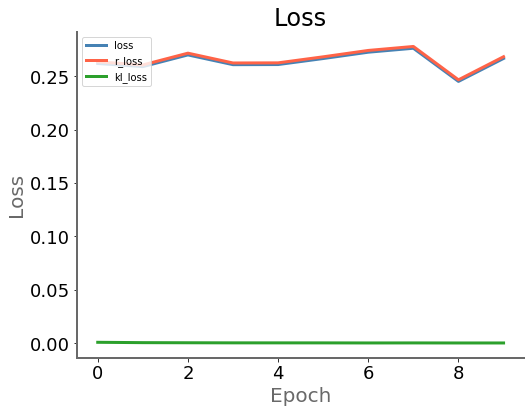

In [11]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

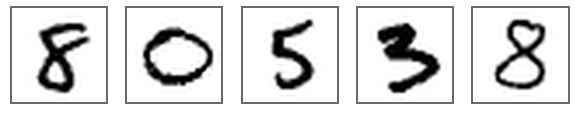

<br>**Encoded/decoded images**

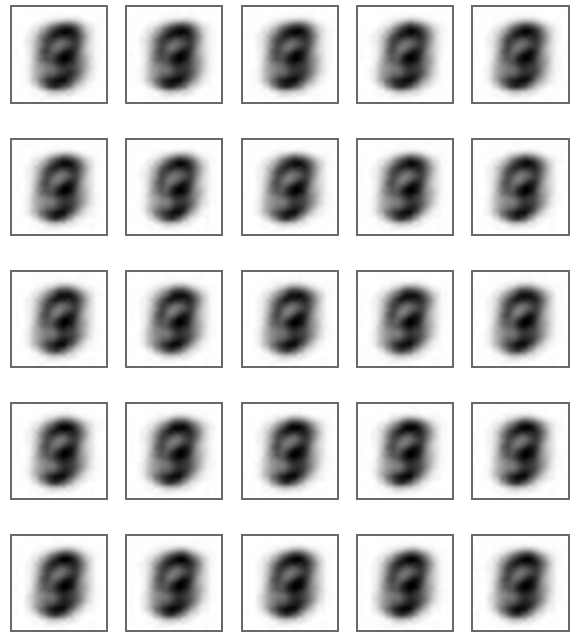

<br>**Original images :**

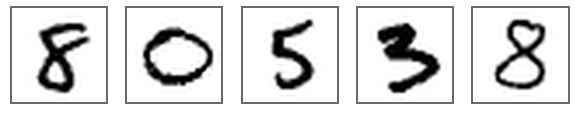

In [12]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

<br>**Generated images from latent space**

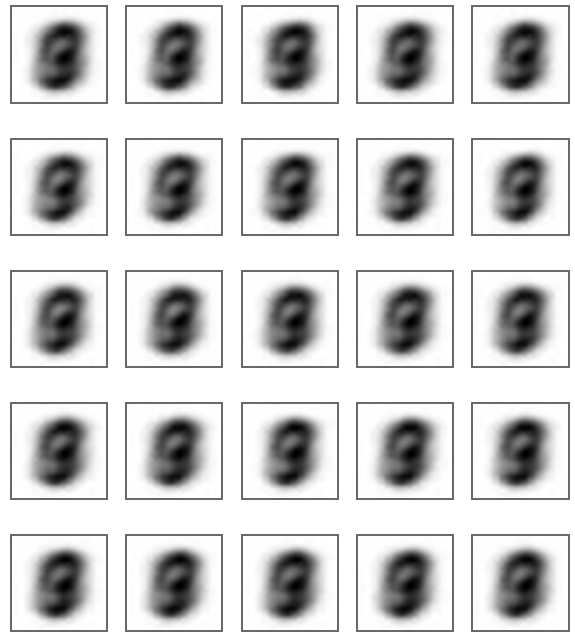

In [13]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [14]:
pwk.end()

End time is : Wednesday 27 January 2021, 19:26:31
Duration is : 00:01:12 334ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>